In [1]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
torch.__version__

(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655


'2.0.1'

In [ ]:
#labeled figure

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
max inners: (400,)


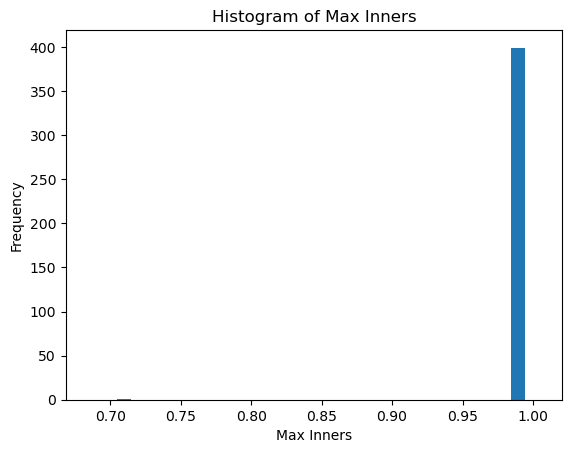

In [23]:
#histograms of inner products
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
unlabeled_data=5000
Complex_eye=torch.eye(400)
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
decoder=nn.Linear(400,training_data[0][0].shape[0], bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init

#decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)decoder.pt' #.92 G_0 init

decoder.load_state_dict(torch.load(locat))


medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)                    
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
max_inners=torch_inners.max(axis=0)
print('max inners:', max_inners.shape)

INC = 0.01
buckets = np.arange(min(max_inners)-2*INC, 1 + INC, INC)
hist, bins = np.histogram(max_inners, bins=buckets)
plt.bar(bins[:-1], hist, width=INC)
plt.xlabel('Max Inners')
plt.ylabel('Frequency')
plt.title('Histogram of Max Inners')
plt.show()
index_list=[]
sum_max_inner_original=0
for i in range(int(outdim*2)):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
 

        

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
(20000,)
.99 inners: 75.92000000000162
minimum occurance of support: 31.0


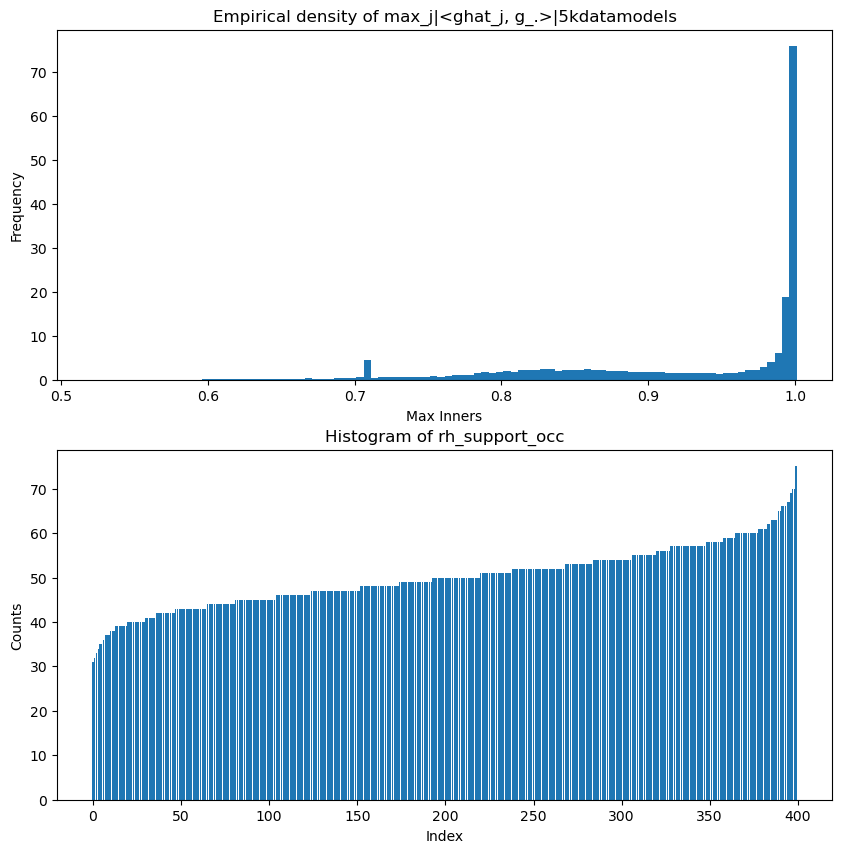

Medium: (1450, 400), Rho: (10000, 400), B: (10000, 1450)
(20000,)
.99 inners: 137.34999999999988
minimum occurance of support: 69.0


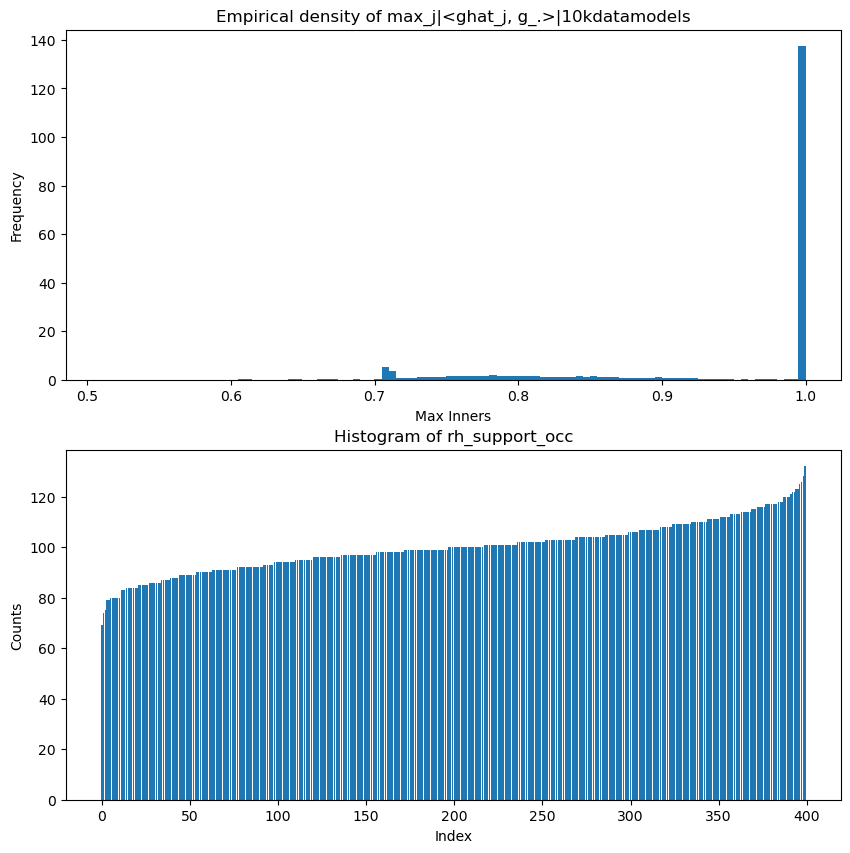

Medium: (1450, 400), Rho: (20000, 400), B: (20000, 1450)
(20000,)
.99 inners: 146.25999999999664
minimum occurance of support: 156.0


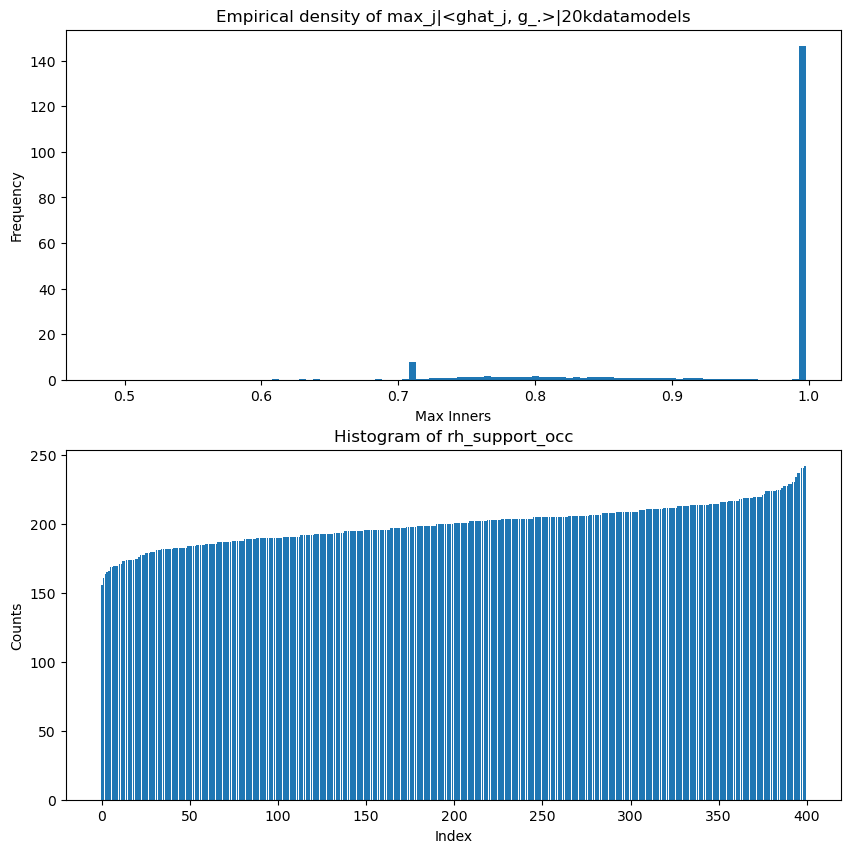

In [45]:
Complex_eye=torch.eye(400)#.to(device)
columns=[]
unlabeled_data=5000

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
for locat in ['5kdatamodels','10kdatamodels','20kdatamodels']:
    decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/{locat}/'
    unlabeled_data=int(locat.split('k')[0])*1000
    training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
    rho=training_data.rho[0]
    rh,_=torch.split(training_data.rho, 400, dim=-1)
    rh_support_occ=torch.sum(rh, dim=0)
    decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    max_list=[]
    columns=[]
    for curr_decoder in decoder_files:
        decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
                # mean over true max over hats
        max_inners=torch_inners.max(axis=0)
        columns.append(medium_hat)
        max_list.append(max_inners)

    max_list=np.array(max_list)
    max_list=max_list.flatten()
    print(max_list.shape)
    INC = 0.005
    
    rh_support_occ=torch.sum(rh, dim=0)
    rh_support_occ=rh_support_occ.cpu().detach().numpy()
    rh_support_occ.sort()
    buckets = np.arange(min(max_list)-2*INC, 1 + INC, INC)
    hist, bins = np.histogram(max_list, bins=buckets, density=True)
    print(f'.99 inners: {hist[-1]}')

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].bar(bins[:-1], hist, width=INC)
    axs[0].set_xlabel('Max Inners')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Empirical density of max_j|<ghat_j, g_.>|'+locat)

    axs[1].bar(range(400), rh_support_occ)
    print(f'minimum occurance of support: {min(rh_support_occ)}')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Counts')
    axs[1].set_title('Histogram of i in support(rho)')

    plt.show()
    index_list=[]
    sum_max_inner_original=0
    for i in range(int(outdim*2)):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    


Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
(50,)
.99 inners: 46


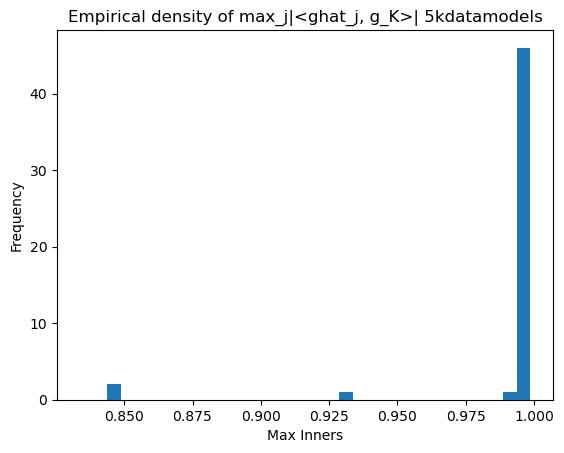

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
(50,)
.99 inners: 48


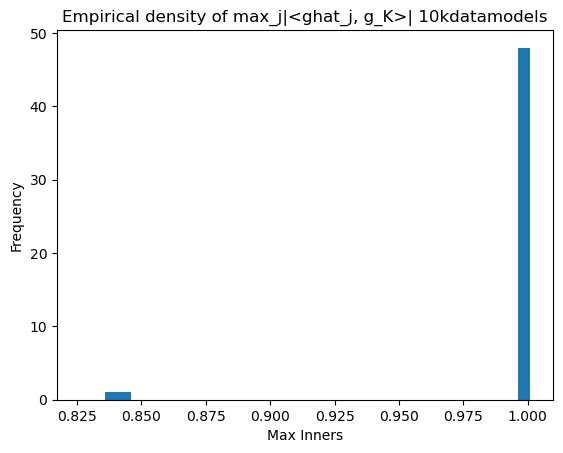

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
(50,)
.99 inners: 50


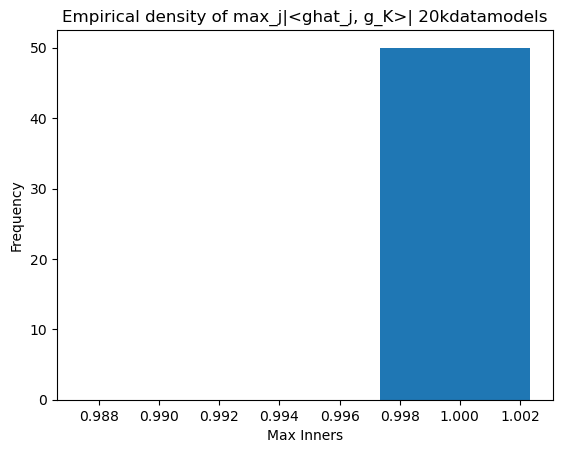

In [26]:
Complex_eye=torch.eye(400)#.to(device)
columns=[]
#column_indx=45
column_indx=0

unlabeled_data=5000


data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
for locat in ['5kdatamodels','10kdatamodels','20kdatamodels']:
    decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/{locat}/'
    training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
    decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    max_list=[]
    columns=[]
    for curr_decoder in decoder_files:
        decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
                # mean over true max over hats
        max_inners=torch_inners.max(axis=0)
        columns.append(medium_hat)
        max_list.append(max_inners[column_indx])

    max_list=np.array(max_list)
    max_list=max_list.flatten()
    print(max_list.shape)
    INC = 0.005
    buckets = np.arange(min(max_list)-2*INC, 1 + INC, INC)
    hist, bins = np.histogram(max_list, bins=buckets)
    print(f'.99 inners: {hist[-1]}')
    plt.bar(bins[:-1], hist, width=INC)
    

    plt.xlabel('Max Inners')
    plt.ylabel('Frequency')
    plt.title('Empirical density of max_j|<ghat_j, g_K>| '+locat)
    plt.show()
    index_list=[]
    sum_max_inner_original=0
    for i in range(int(outdim*2)):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    


Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
max inners: (400,)


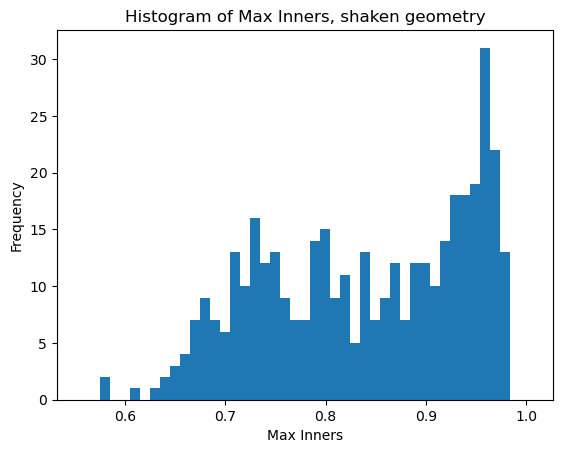

In [29]:
#histograms of inner products
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.
unlabeled_data=5000
Complex_eye=torch.eye(400)
data_path=os.path.join(cwd,'Data/PNAS-regime_guassian_01perc_offgrid_all_seeds/PNAS-regime_guassian_01perc_offgrid_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
locat=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/wide_models/decoder_5000_0_13-56-06.pt'
decoder.load_state_dict(torch.load(locat))


medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)                    
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
max_inners=torch_inners.max(axis=0)
print('max inners:', max_inners.shape)

INC = 0.01
buckets = np.arange(min(max_inners)-2*INC, 1 + INC, INC)
hist, bins = np.histogram(max_inners, bins=buckets)
plt.bar(bins[:-1], hist, width=INC)
plt.xlabel('Max Inners')
plt.ylabel('Frequency')
plt.title('Histogram of Max Inners, shaken geometry')
plt.show()
index_list=[]
sum_max_inner_original=0
for i in range(int(outdim*2)):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
 

        

Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
max inners: (361,)


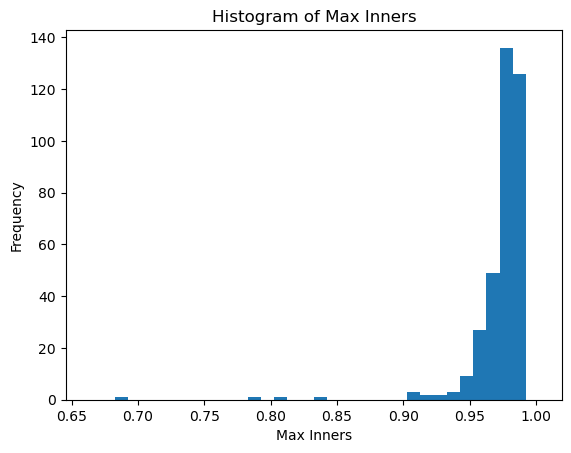

In [30]:
#histograms of inner products
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.
unlabeled_data=5000
Complex_eye=torch.eye(19*19)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)

indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
#locat=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/wide_models/decoder_5000_0_16-23-45.pt'
timestampStr = '16-23-45'
locat=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10khighcohdatamodels/decoder{timestampStr}.pt'
decoder.load_state_dict(torch.load(locat))


medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)                    
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
max_inners=torch_inners.max(axis=0)
print('max inners:', max_inners.shape)

INC = 0.01
buckets = np.arange(min(max_inners)-2*INC, 1 + INC, INC)
hist, bins = np.histogram(max_inners, bins=buckets)
plt.bar(bins[:-1], hist, width=INC)
plt.xlabel('Max Inners')
plt.ylabel('Frequency')
plt.title('Histogram of Max Inners Folxy-Lox')
plt.show()
index_list=[]
sum_max_inner_original=0
for i in range(int(outdim*2)):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
 

        